In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions, BenchmarkTools

In [ ]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

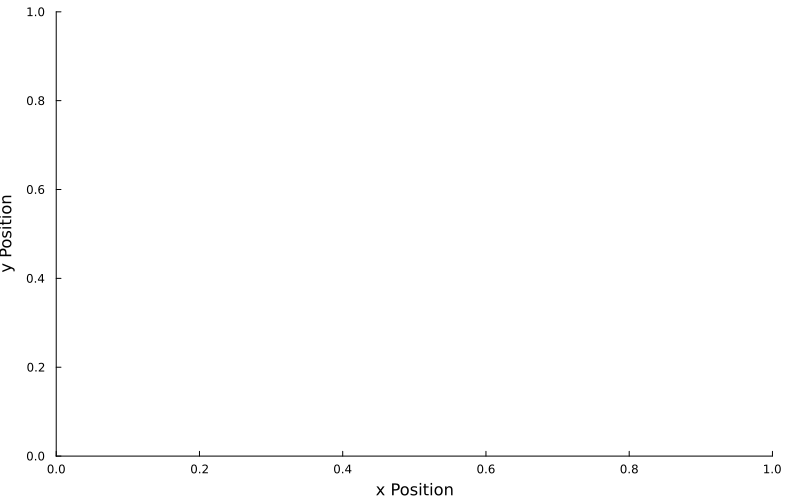

In [4]:
# Define the plot
num_points = 100

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2], xlabel="x Position", ylabel="y Position", color=:viridis, colorbar_title="Amplitude", size=plot_size, grid=false)

In [5]:
# ops = gaussian_operators_2D(0.05, plt_grid_x1, plt_grid_x2)

ops = fourier_operators_2D(10, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}(441, 0.047619047619047616, -10:10, -10:10), var"#Φ#18"{var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}}(var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}(441, 0.047619047619047616, -10:10, -10:10)), var"#adjΦ#19"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#16#20"{var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}}}([0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0], [0.0 0.0 … 0.0 0.0; 0.01 0.01 … 0.01 0.01; … ; 0.99 0.99 … 0.99 0.99; 1.0 1.0 … 1.0 1.0], var"#adjΦ#16#20"{var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}}(var"#ϕ#17"{Int64, Float64, UnitRange{Int64}, UnitRange{Int64}}(441, 0.047619047619047616, -10:10, -10:10))))

## Pre-certificate

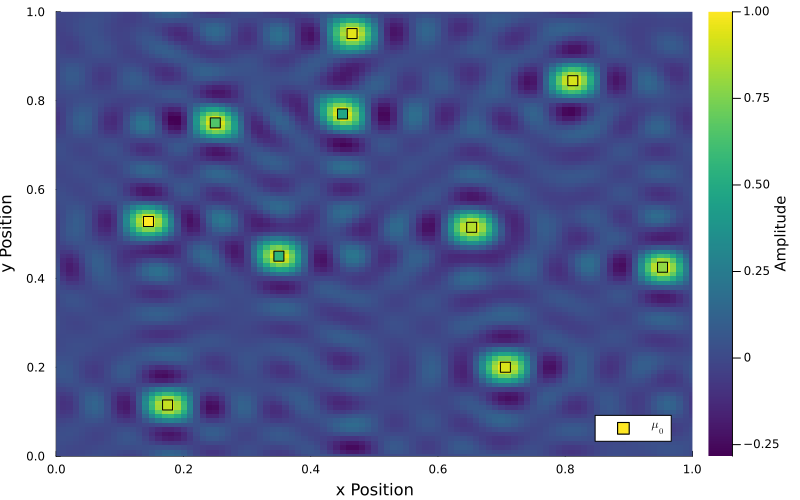

In [6]:
x0 = [
    [0.145, 0.175, 0.465, 0.706, 0.653, 0.953, 0.812, 0.25, 0.35, 0.45],
    [0.528, 0.115, 0.951, 0.200, 0.515, 0.425, 0.845, 0.75, 0.45, 0.77]
]
a0 = [1.000, 0.888, 0.947, 0.929, 0.857, 0.788, 0.921, 0.65, 0.55, 0.47]

μ0 = DiscreteMeasure(x0, a0)

ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

In [7]:
maximum(abs.(ηV))

1.0000000000000013

### SFW

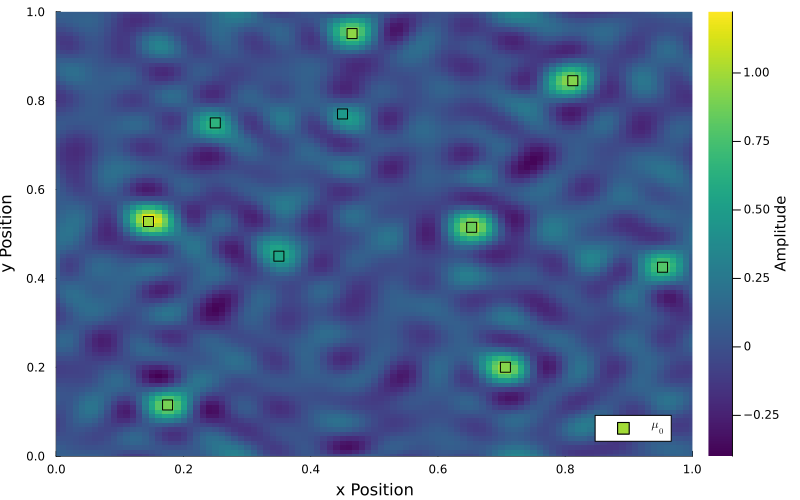

In [15]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 1
Random.seed!(1)
y = add_noise(y0, noise_level)

plt_obs = deepcopy(plt)

# heatmap!(plt_obs, grid, grid, reshape(y, size(plt_grid_x1)), color=:viridis)
heatmap!(plt_obs, grid, grid, ops.adjΦ(y), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

BFGS on L1 norm

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:01


DiscreteMeasure([[0.7052765816385168, 0.14697398713831958, 0.8063564474155653, 0.6537955055526017, 0.4641170364735992, 0.2457669957810268, 0.34928521719861294, 0.954280262006187, 0.1747958489035817, 0.747843122128746, 0.45833596033728197], [0.1984135688686873, 0.5324219998915926, 0.8448413567191096, 0.5150424043994325, 0.9532840741828021, 0.7441726868027162, 0.4570150903758364, 0.42744249892912106, 0.11392207151199336, 0.6640278835966237, 0.7649156020882502]], [0.8082415062863144, 0.9904130857925939, 0.7638508535141696, 0.8182744277094958, 0.7118182766654345, 0.4131362442950021, 0.4005810237254052, 0.6039270587730537, 0.7196921040373457, -0.1923589659987039, 0.2667513838436712], 2, 11)

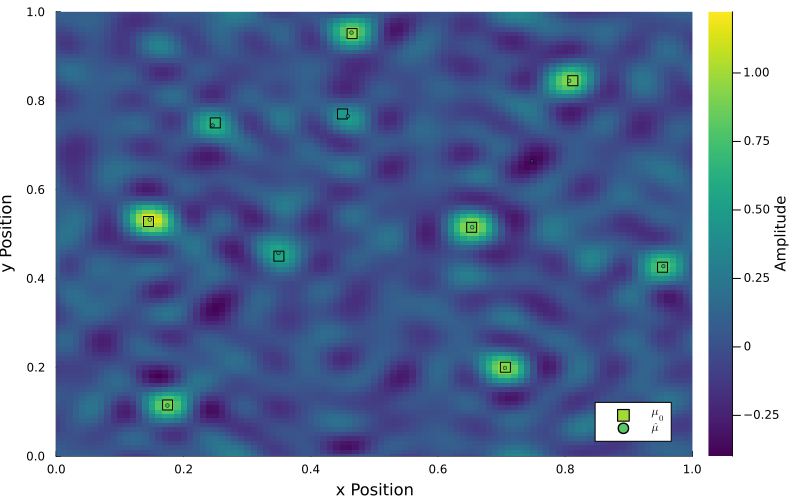

In [16]:
prob = BLASSO(y, ops, domain, .2noise_level)
solve!(prob, options=Dict(:maxits => length(a0) + 1))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

LBFGS

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:03


DiscreteMeasure([[0.7053867848056261, 0.14698266382451847, 0.8063595804684668, 0.653696573682177, 0.46411923247840975, 0.24565725855828124, 0.34921145274353366, 0.9542813970828141, 0.17481418389945594, 0.7478003823463563, 0.7478003823486148], [0.19845741643150683, 0.5324254129349033, 0.8448995670094656, 0.5150605315952204, 0.954395920805655, 0.7446243646069233, 0.4570192541133941, 0.4274296353892338, 0.11392992565062116, 0.6640677116099652, 0.6640677116093544]], [0.8091811906737475, 0.990099880810452, 0.7640745506081734, 0.8179357234317811, 0.7094726279735686, 0.42925231718241535, 0.40155854651239903, 0.6037508958224495, 0.7195674456390851, 1.011372137936143e-16, 1.0113721379361028e-16], 2, 11)

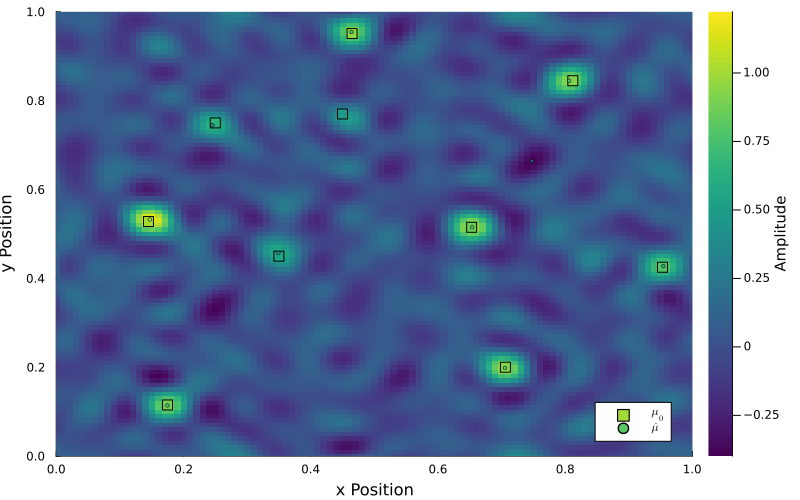

In [17]:
prob = BLASSO(y, ops, domain, .2noise_level)
solve!(prob, options=Dict(:maxits => length(a0) + 1, :descent => :LBFGS, :positivity => true))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

Smooth bilevel

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:02


DiscreteMeasure([[0.7052765816358707, 0.14697398713971535, 0.8063564474145122, 0.6537955055524672, 0.46411703647239594, 0.2457669957867857, 0.34928521720915795, 0.9542802620070207, 0.17479584890326477, 0.747843122135546, 0.458335960327543], [0.19841356886521247, 0.5324219998905246, 0.8448413567193884, 0.5150424044004388, 0.9532840741774925, 0.7441726867953186, 0.45701509038127447, 0.4274424989240431, 0.11392207151237918, 0.6640278835504276, 0.7649156021061058]], [0.8082415061898707, 0.990413085637766, 0.7638508534724234, 0.8182744276593059, 0.7118182763862372, 0.4131362442654782, 0.400581023443944, 0.6039270587683273, 0.7196921041185478, -0.19235896614473777, 0.26675138485872163], 2, 11)

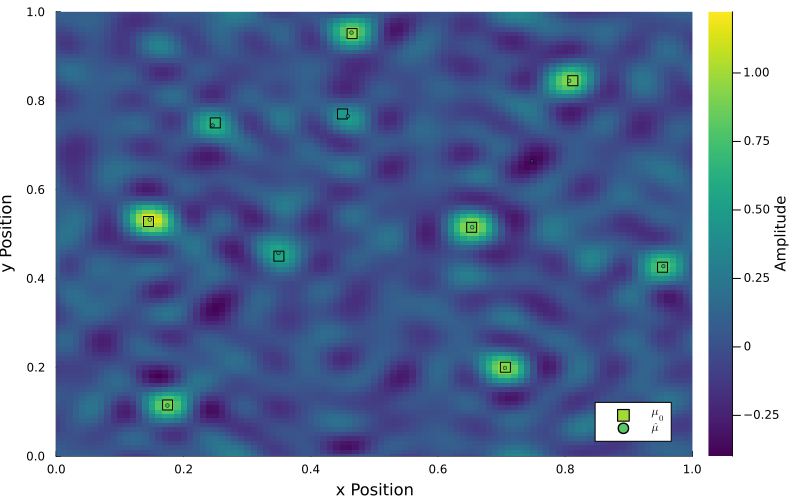

In [18]:
prob = BLASSO(y, ops, domain, 0.2noise_level)
solve!(prob, options=Dict(:maxits => length(a0) + 1, :descent => :smooth))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)